In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")

import json
import requests

import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set random seed for reproducibility
tf.random.set_seed(42)

In [122]:
#endpoint = 'https://min-api.cryptocompare.com/data/histominute' # minute
#endpoint = 'https://min-api.cryptocompare.com/data/histohour' # hour
endpoint = 'https://min-api.cryptocompare.com/data/histoday' # day
res = requests.get(endpoint + '?fsym=BTC&tsym=USDT&limit=1000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time') #, inplace=True, drop=False)
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [117]:
df.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [125]:
# Filter the data
# forecast data
forecast_df = df.loc['2022-05-01':'2022-12-31']
#history data
df = df.loc['2019-01-01':'2022-04-30']

In [127]:
#df.head()
df.tail()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-08-30,9676.60,9365.91,9490.83,200935.58,1.915662e+09,9582.81,direct,
2019-08-31,9677.42,9449.92,9582.81,133556.50,1.279582e+09,9589.32,direct,
2019-09-01,9804.10,9530.93,9589.32,149762.14,1.441930e+09,9729.01,direct,
2019-09-02,10430.32,9718.77,9729.01,246013.39,2.462865e+09,10340.88,direct,
2019-09-03,10756.98,10276.43,10340.88,276139.88,2.904543e+09,10607.38,direct,


In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3.5})
plt.rcParams['figure.dpi'] = 360
sns.lineplot(data=df, x="time", y="close")
plt.xlabel("Date") 
plt.ylabel("Close value (USD)") 
#plt.title("Evolution of Bitcoin price")
horizontalalignment='center'
sns.despine()

In [33]:
# Create variable 'TOMORROW_CLOSE' which shifts 'Close' up by 1
df['TOMORROW_CLOSE'] = df['close'].shift(-1,fill_value=0)

In [35]:
# drop last row because we shifted value (remember this when you add your forecasting data)
df.drop(df.tail(1).index,inplace=True) 

In [37]:
df = df.drop(columns=['close'])

In [57]:
df.head()
#df.tail()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-12-01,59045.48,56466.21,56915.36,111976.83,6.429900e+09,57187.25,direct,
2021-12-02,57372.10,55856.16,57187.25,94468.57,5.350299e+09,56487.38,direct,
2021-12-03,57552.02,52150.31,56487.38,140396.42,7.761286e+09,53646.19,direct,
2021-12-04,53854.34,42748.58,53646.19,203903.11,9.854144e+09,49169.88,direct,
2021-12-05,49671.39,47757.57,49169.88,125543.08,6.156655e+09,49391.09,direct,


In [58]:
# Split train data (80%) and test data (20%)
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

In [59]:
# Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

AttributeError: ignored

<Figure size 4320x2160 with 0 Axes>

In [41]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]
# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [42]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [43]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (390, 10, 5)
y_train.shape:  (1590, 1)
X_test.shape:  (390, 10, 5)
y_test.shape:  (1590, 1)


In [44]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

In [ ]:
#Plot train and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [47]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [48]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

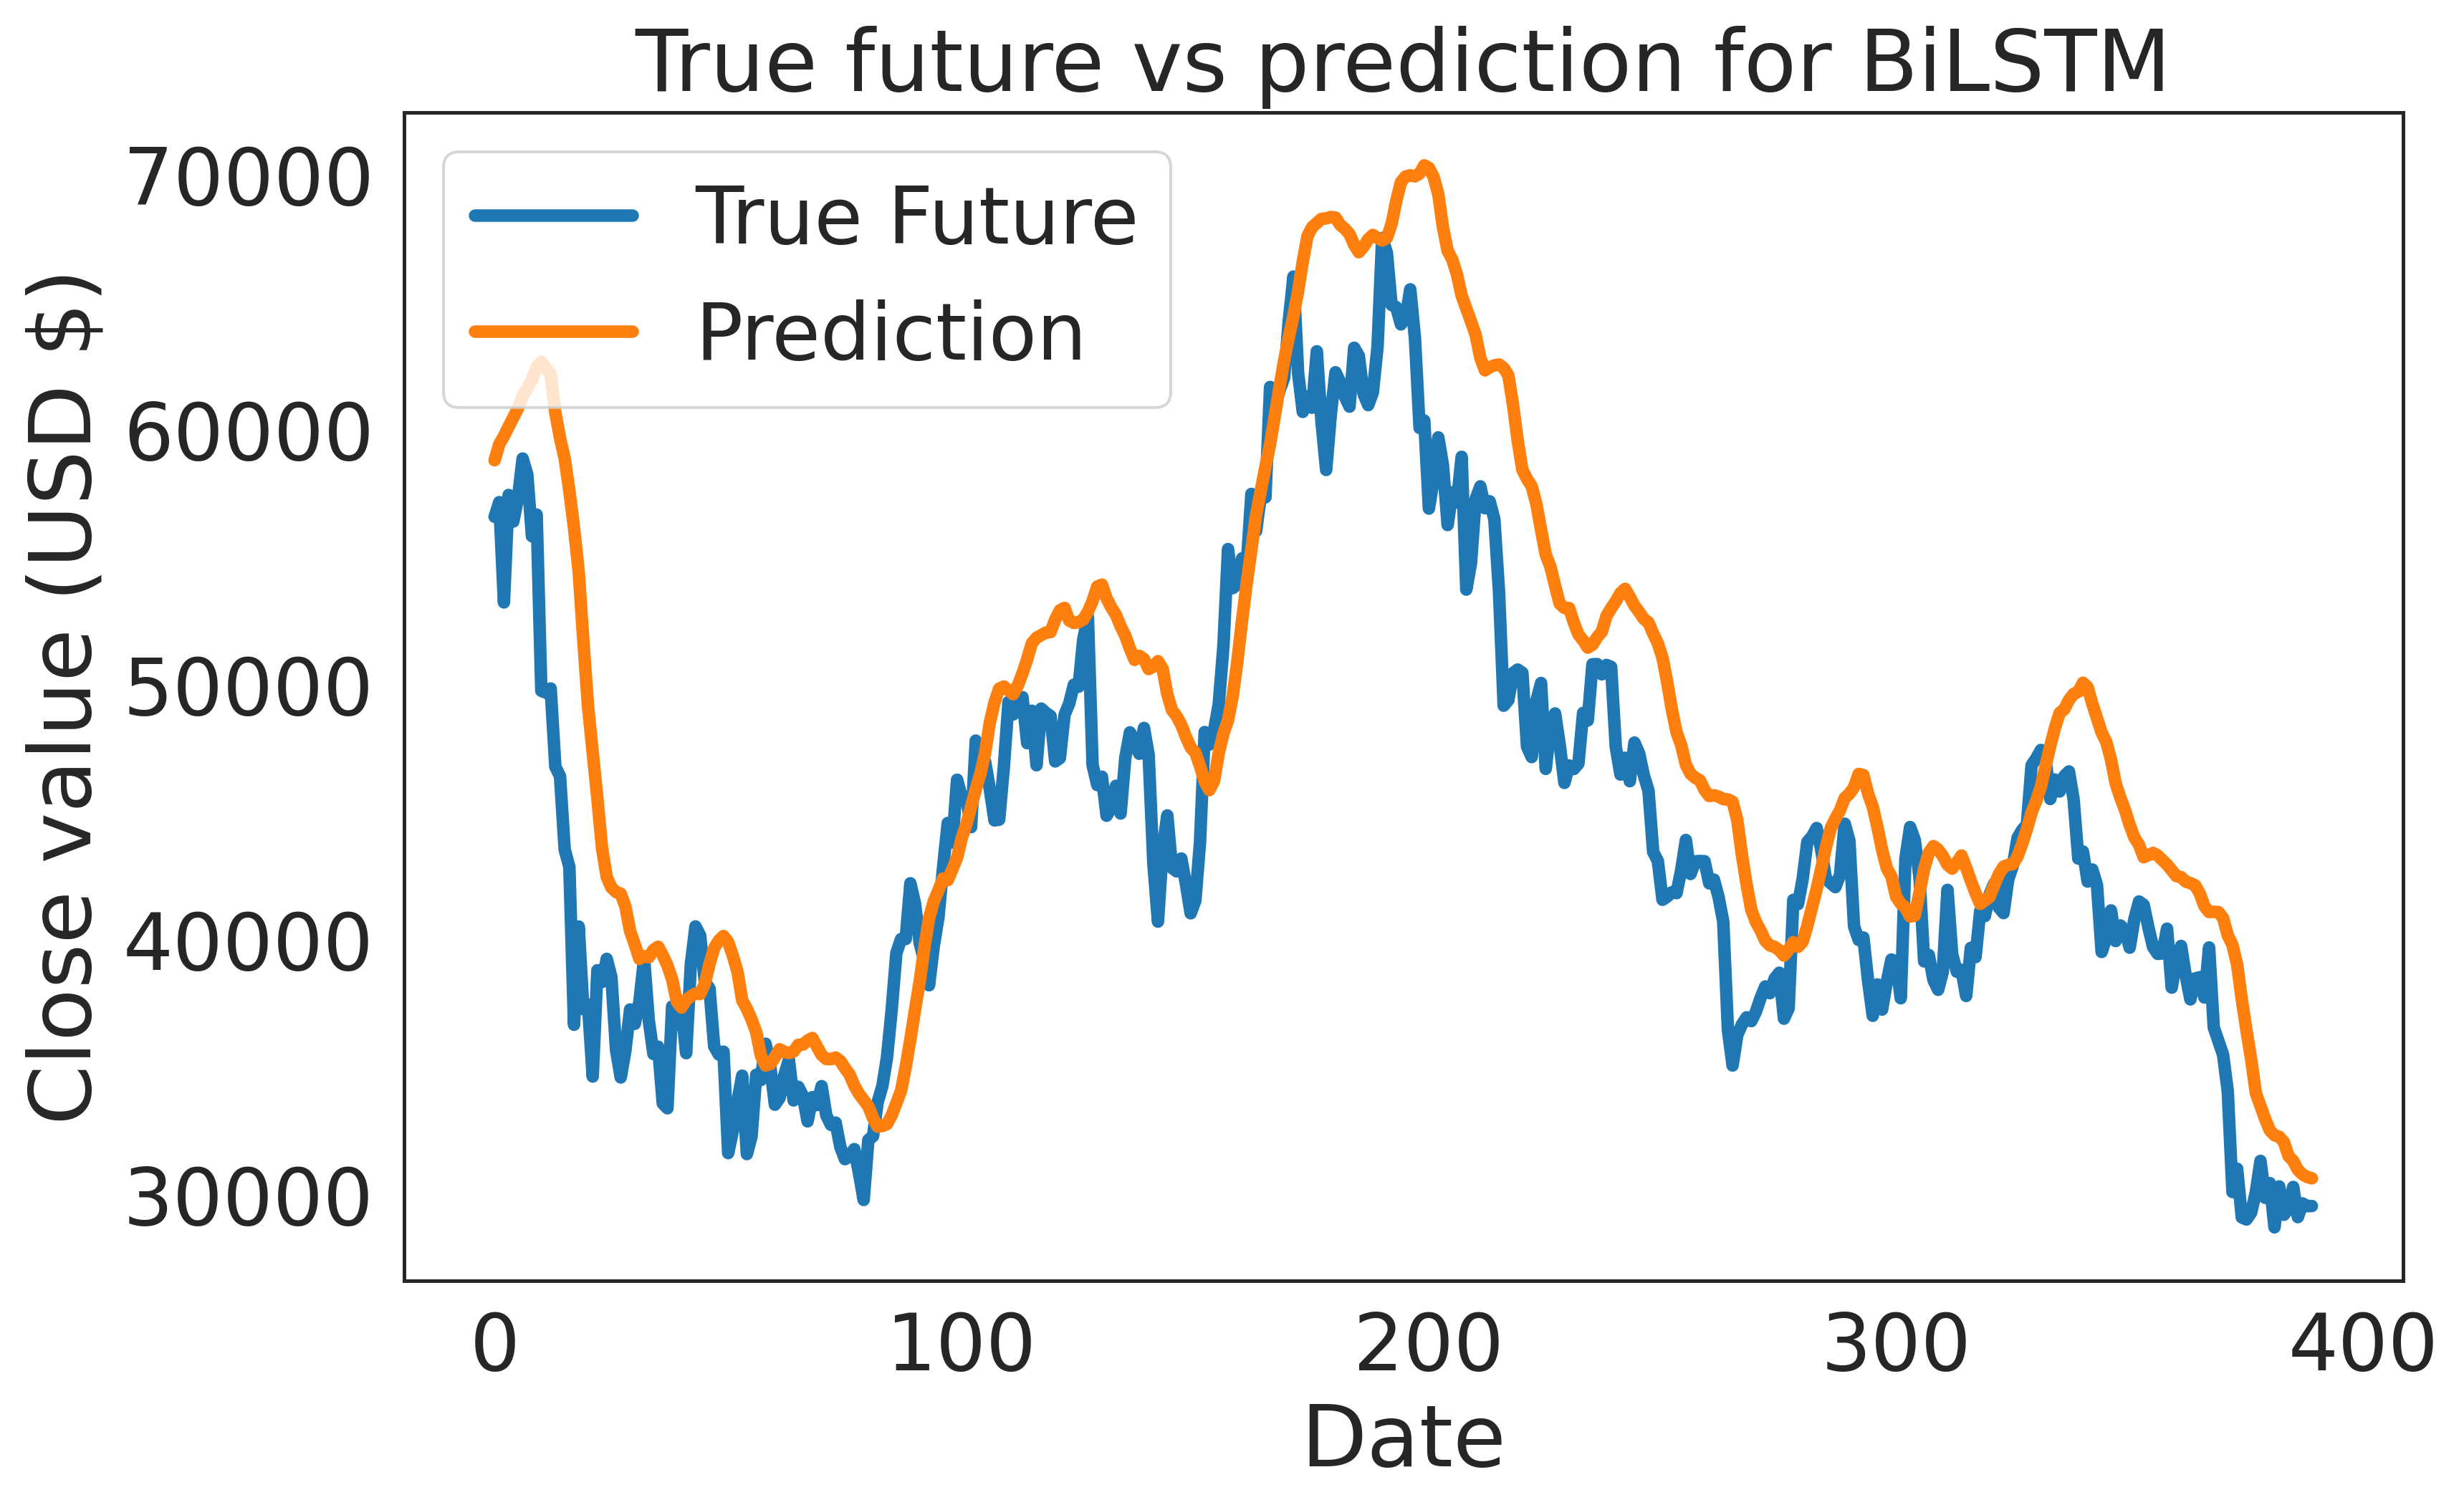

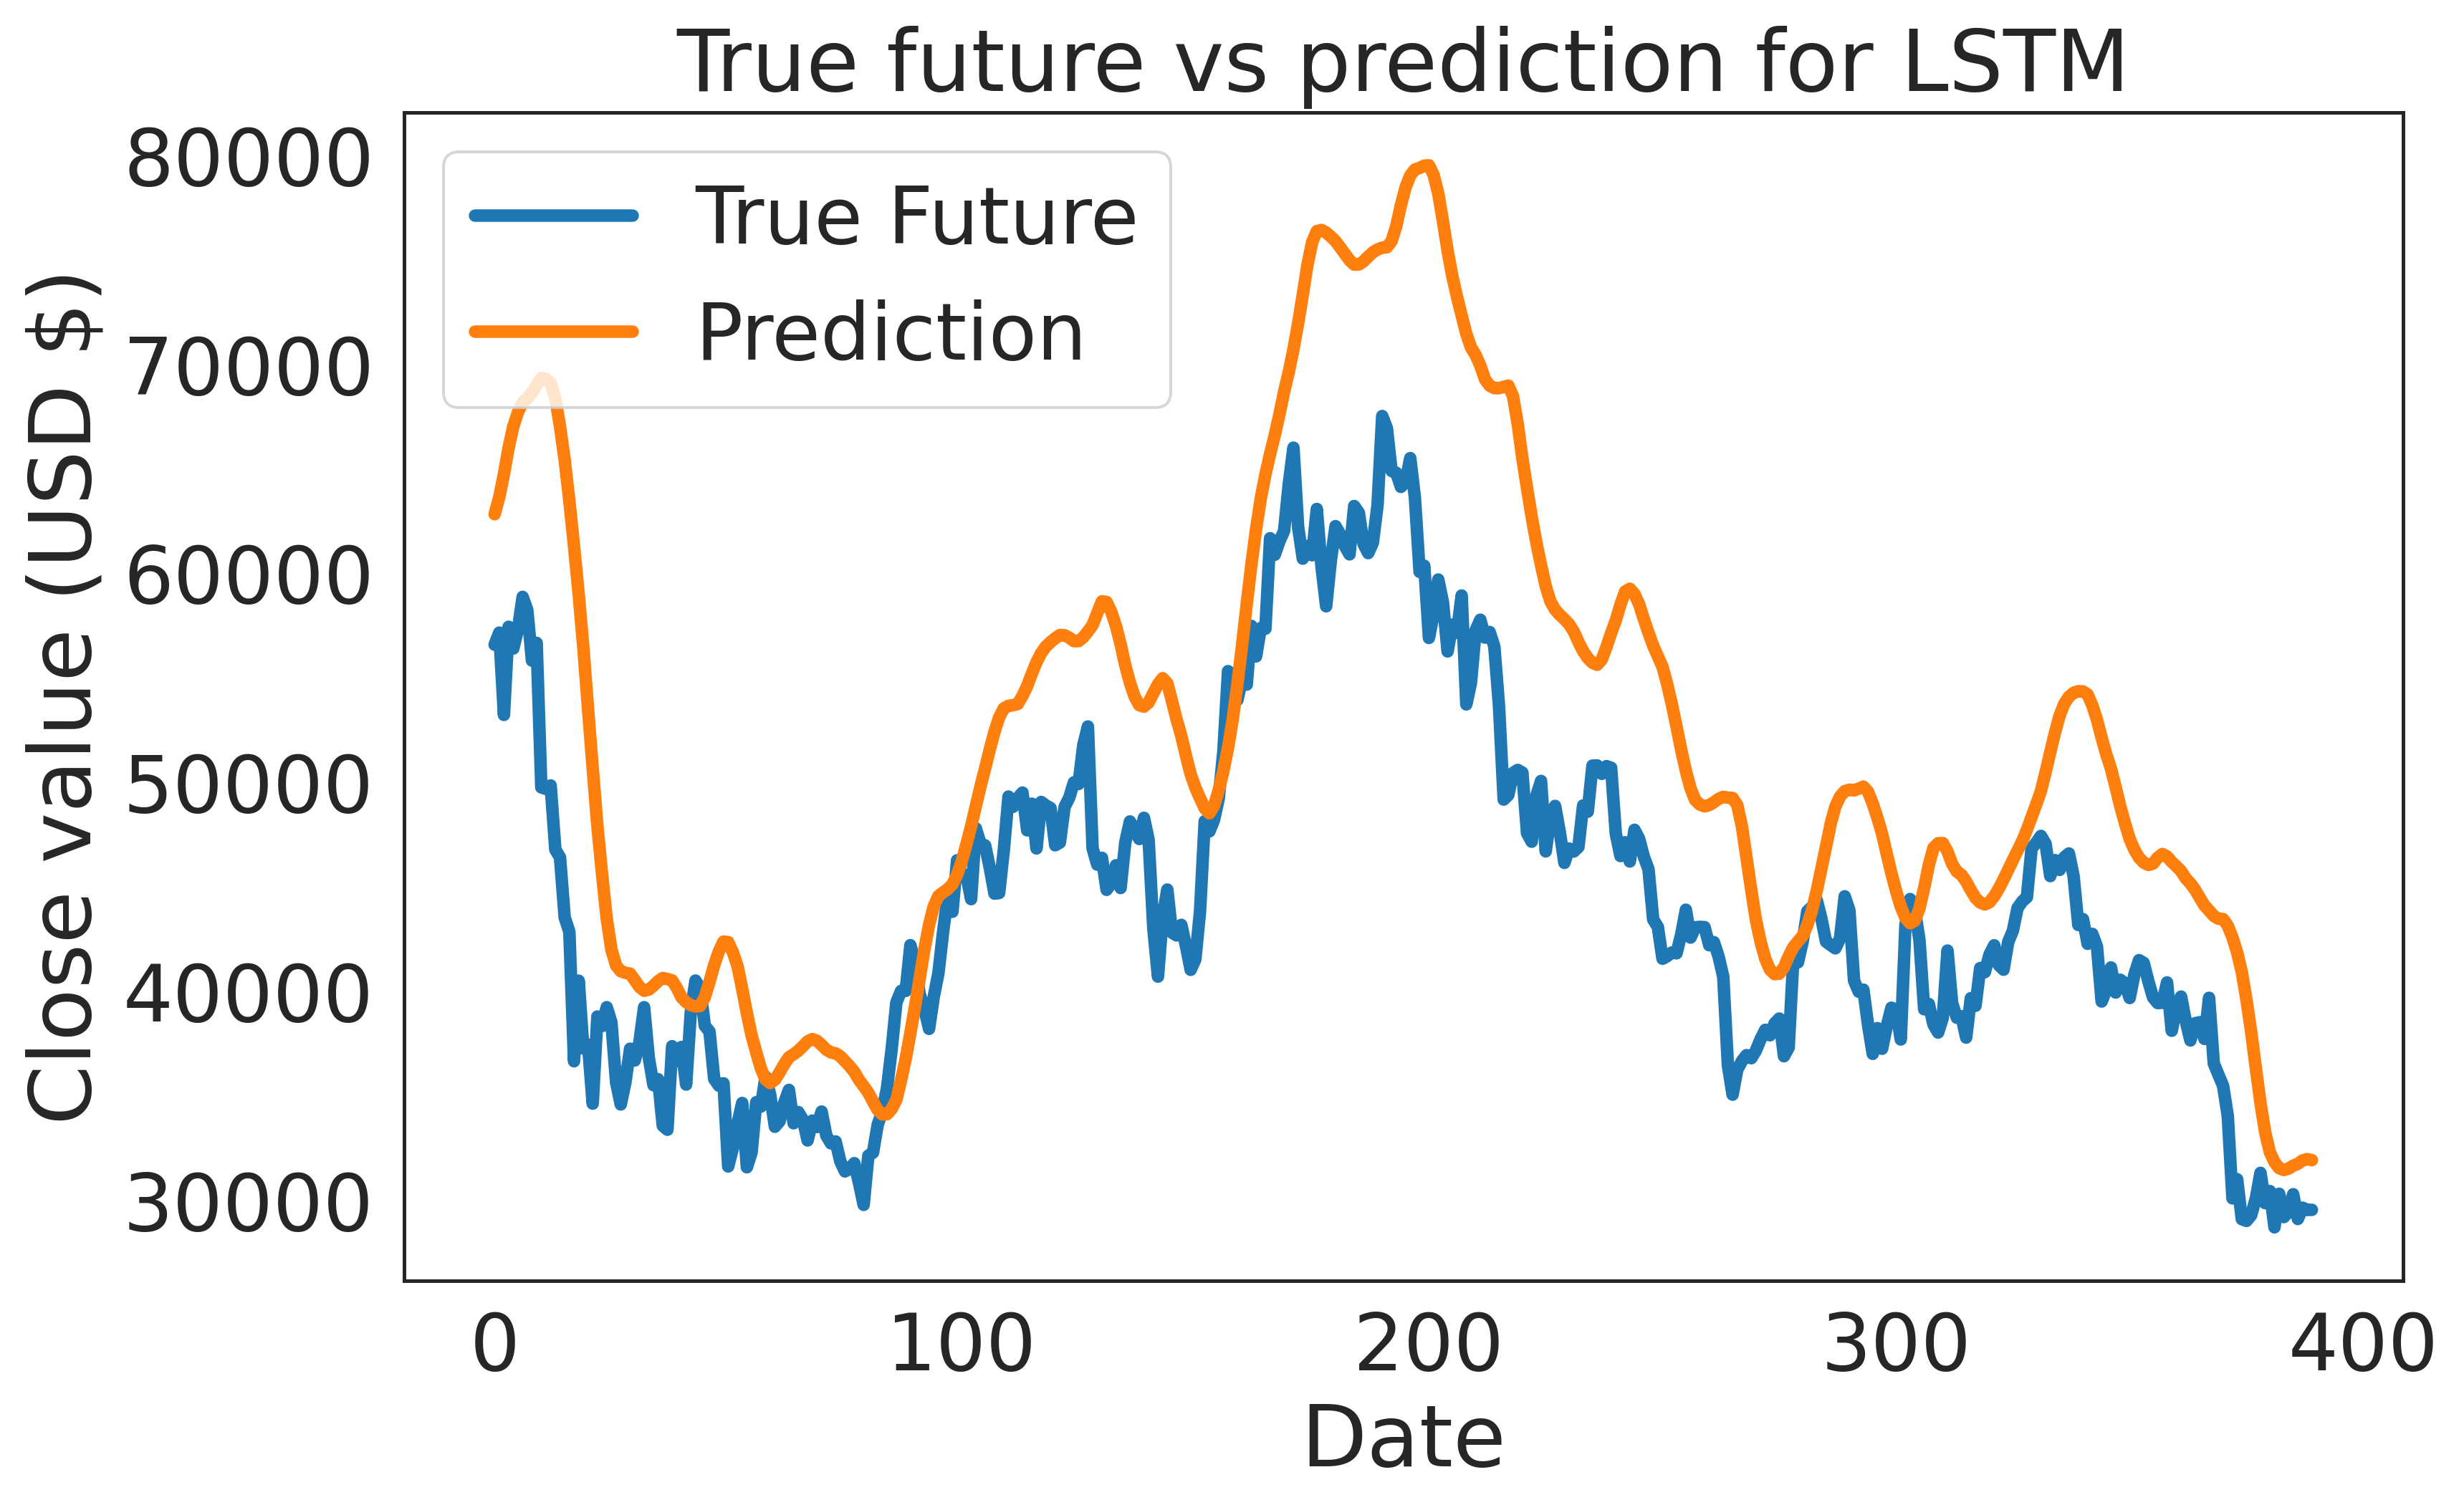

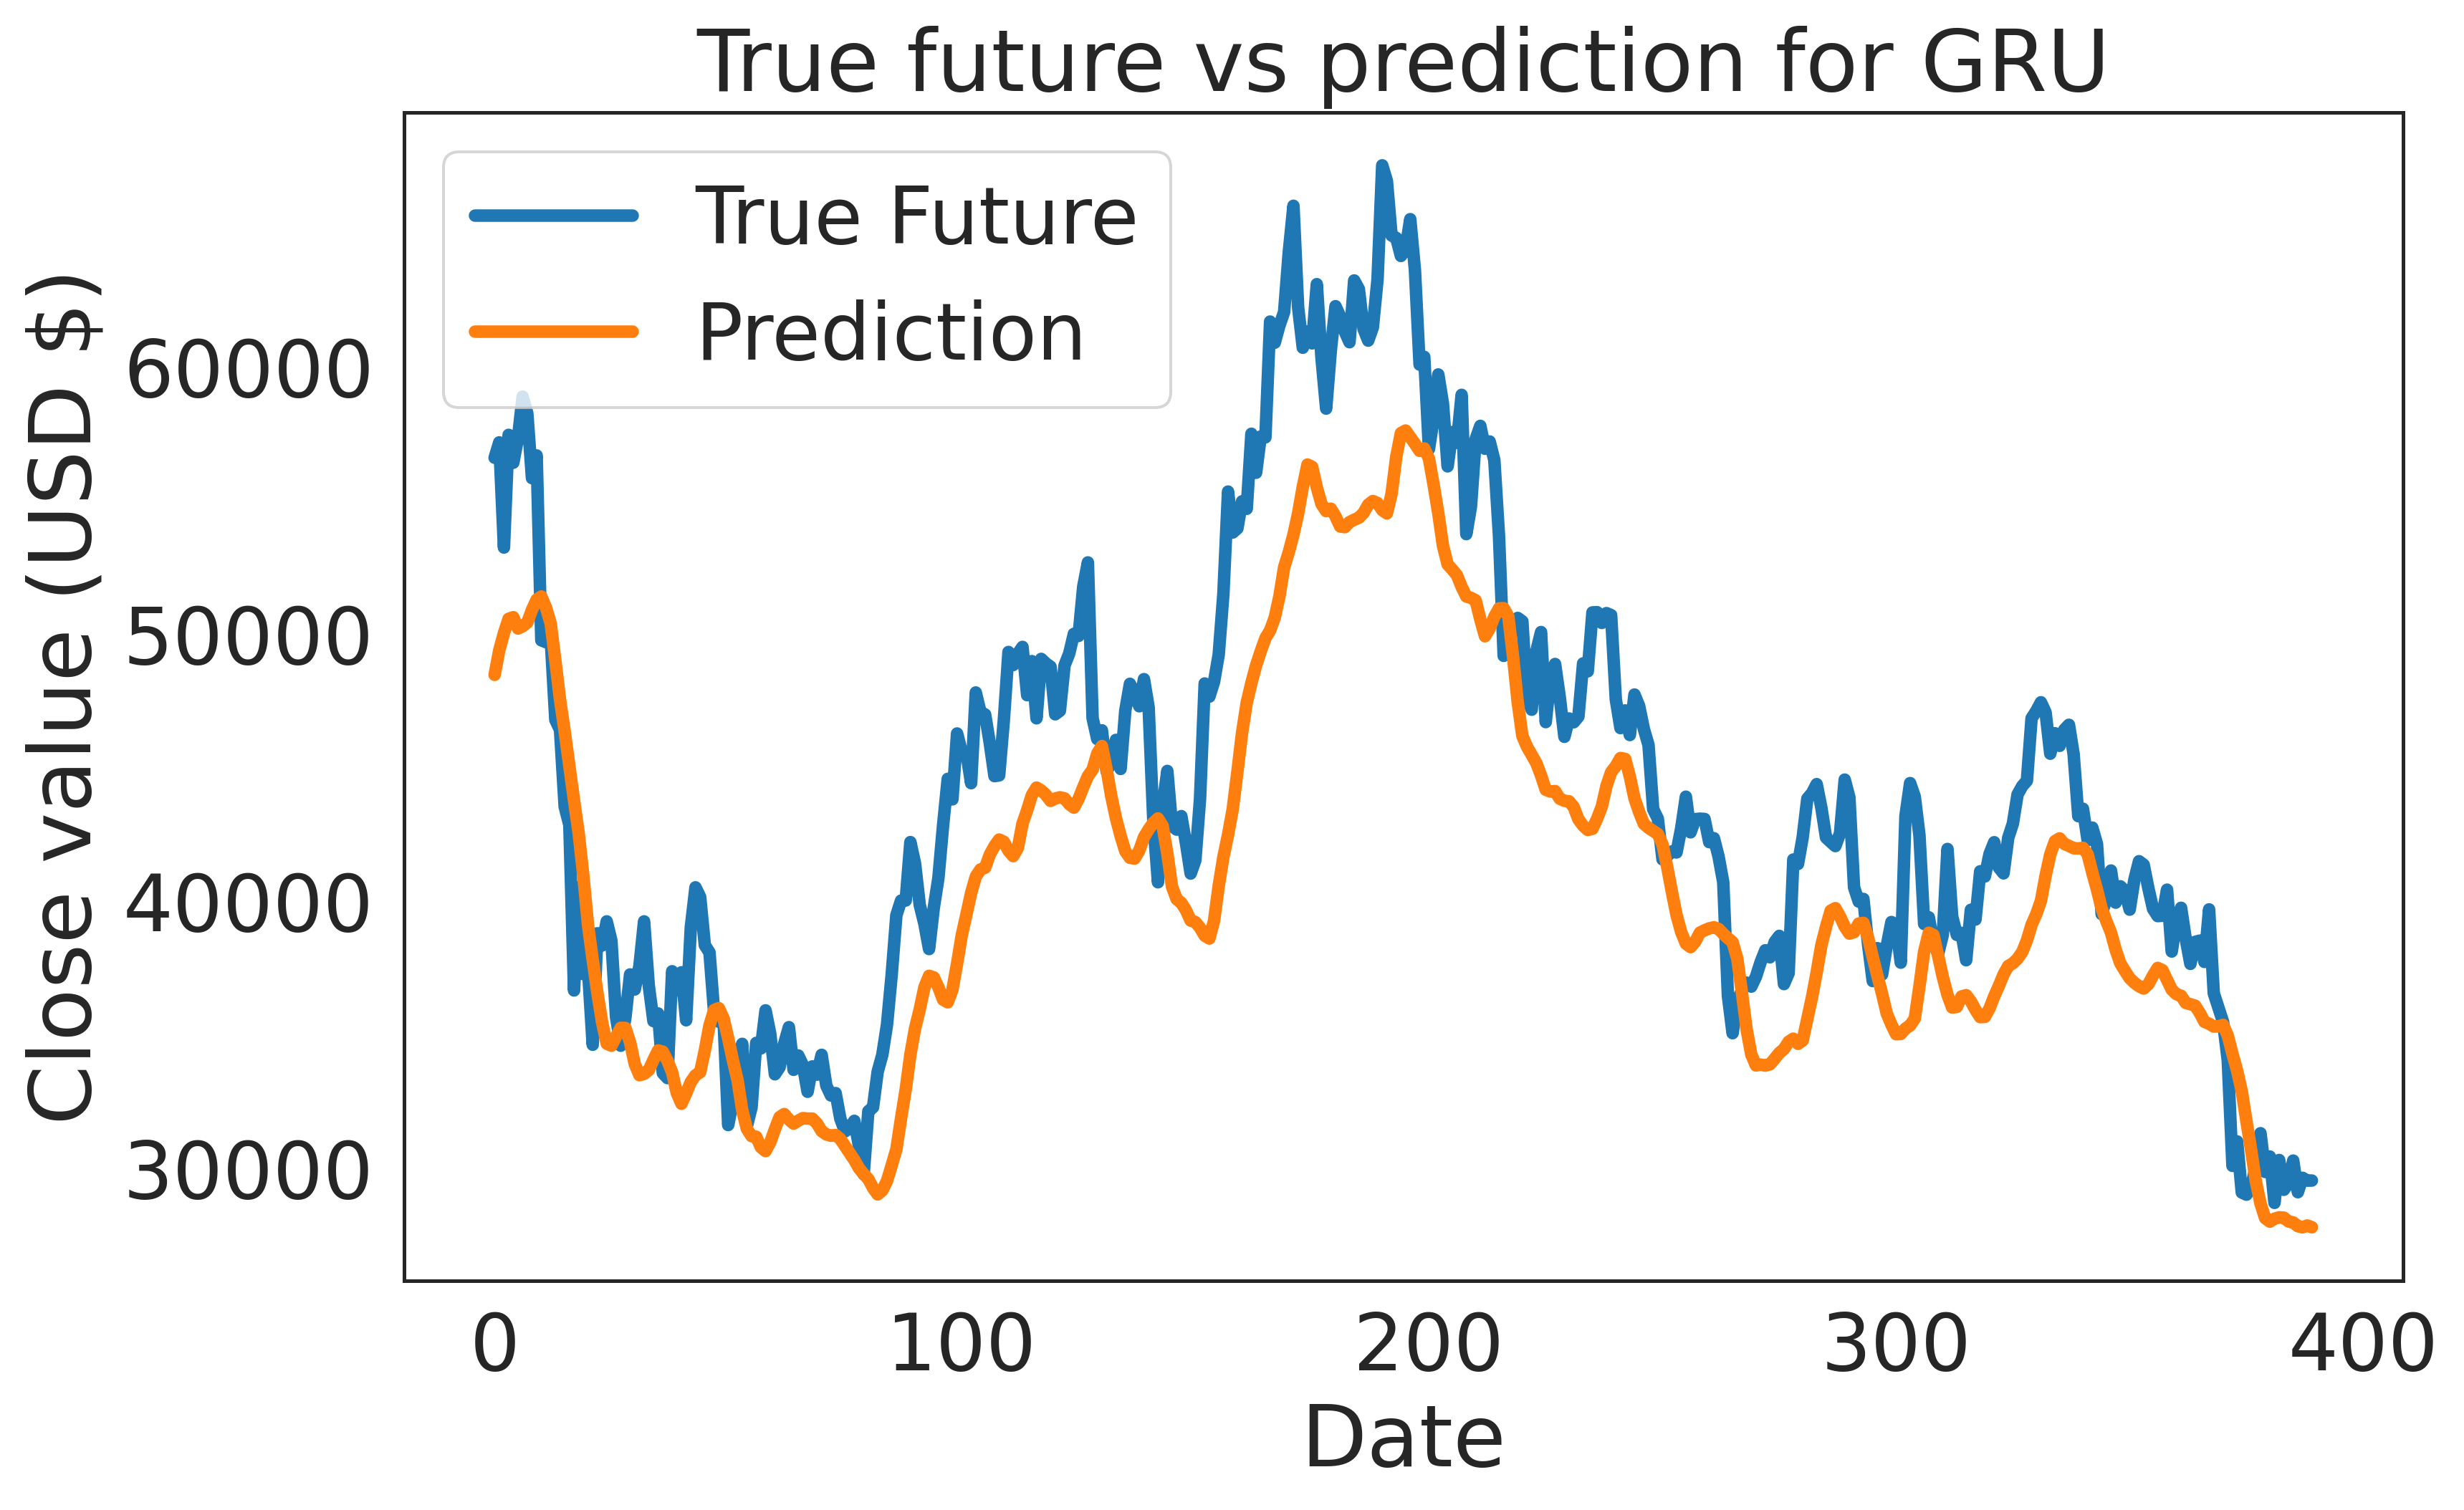

In [49]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
   
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [50]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 4402.2040
Root Mean Square Error: 5441.8013

LSTM:
Mean Absolute Error: 7694.7648
Root Mean Square Error: 9188.9792

GRU:
Mean Absolute Error: 4107.6039
Root Mean Square Error: 4909.0969



In [52]:
# Import forecast data
#endpoint = 'https://min-api.cryptocompare.com/data/histominute' # minute
#endpoint = 'https://min-api.cryptocompare.com/data/histohour' # hour
endpoint = 'https://min-api.cryptocompare.com/data/histoday' # day
#res = requests.get(endpoint + '?fsym=BTC&tsym=USDT&limit=2000')
res = requests.get(endpoint + '?fsym=BTC&tsym=USDT&toTs=1640995199')
forecast_df = pd.DataFrame(json.loads(res.content)['Data'])
forecast_df = forecast_df.set_index('time')
forecast_df.index = pd.to_datetime(forecast_df.index, unit='s')
target_col = 'close'

In [53]:
forecast_df.head(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-12-01,59045.48,56466.21,56915.36,111976.83,6.429900e+09,57187.25,direct,
2021-12-02,57372.10,55856.16,57187.25,94468.57,5.350299e+09,56487.38,direct,
2021-12-03,57552.02,52150.31,56487.38,140396.42,7.761286e+09,53646.19,direct,
2021-12-04,53854.34,42748.58,53646.19,203903.11,9.854144e+09,49169.88,direct,
2021-12-05,49671.39,47757.57,49169.88,125543.08,6.156655e+09,49391.09,direct,
2021-12-06,50852.59,47185.55,49391.09,129348.01,6.305094e+09,50446.48,direct,
2021-12-07,51917.57,50045.17,50446.48,123099.23,6.275920e+09,50588.25,direct,
2021-12-08,51168.58,48648.50,50588.25,93980.91,4.714965e+09,50461.22,direct,
2021-12-09,50775.30,47329.44,50461.22,103066.35,5.050834e+09,47563.82,direct,


In [ ]:
# We see Date is an object, so we have to convert it to datetime
forecast_df['Date'] = forecast_df['Date'].astype('datetime64[ns]')

In [ ]:
forecast_df = forecast_df.set_index('Date')

In [ ]:
forecast_df.shape

(12, 5)

In [ ]:
forecast_df.dtypes

Open         float64
High         float64
Low          float64
Volume         int64
MarketCap    float64
dtype: object

In [ ]:
forecast_df.Volume = forecast_df.Volume.astype(float)

In [ ]:
X_new = forecast_df.loc['2021-01-12': '2021-01-23',:]
X_new

,Open,High,Low,Volume,MarketCap
Date,,,,,
2021-01-12,35516.36,36568.53,32697.98,7.477328e+10,6.309200e+11
2021-01-13,33915.12,37599.96,32584.67,6.936432e+10,6.940700e+11
2021-01-14,37325.11,39966.41,36868.56,6.361599e+10,7.289040e+11
2021-01-15,39156.71,39577.71,34659.59,6.776076e+10,6.850060e+11
2021-01-16,36821.65,37864.37,35633.55,5.770619e+10,6.730010e+11
2021-01-17,36163.65,36722.35,34069.32,5.235985e+10,6.658320e+11
2021-01-18,35792.24,37299.29,34883.84,4.951170e+10,6.810000e+11
2021-01-19,36642.23,37755.89,36069.81,5.724420e+10,6.710000e+11
2021-01-20,36050.11,36378.33,33570.48,6.683457e+10,6.610000e+11


In [ ]:
# Plot history and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (US $)')
    

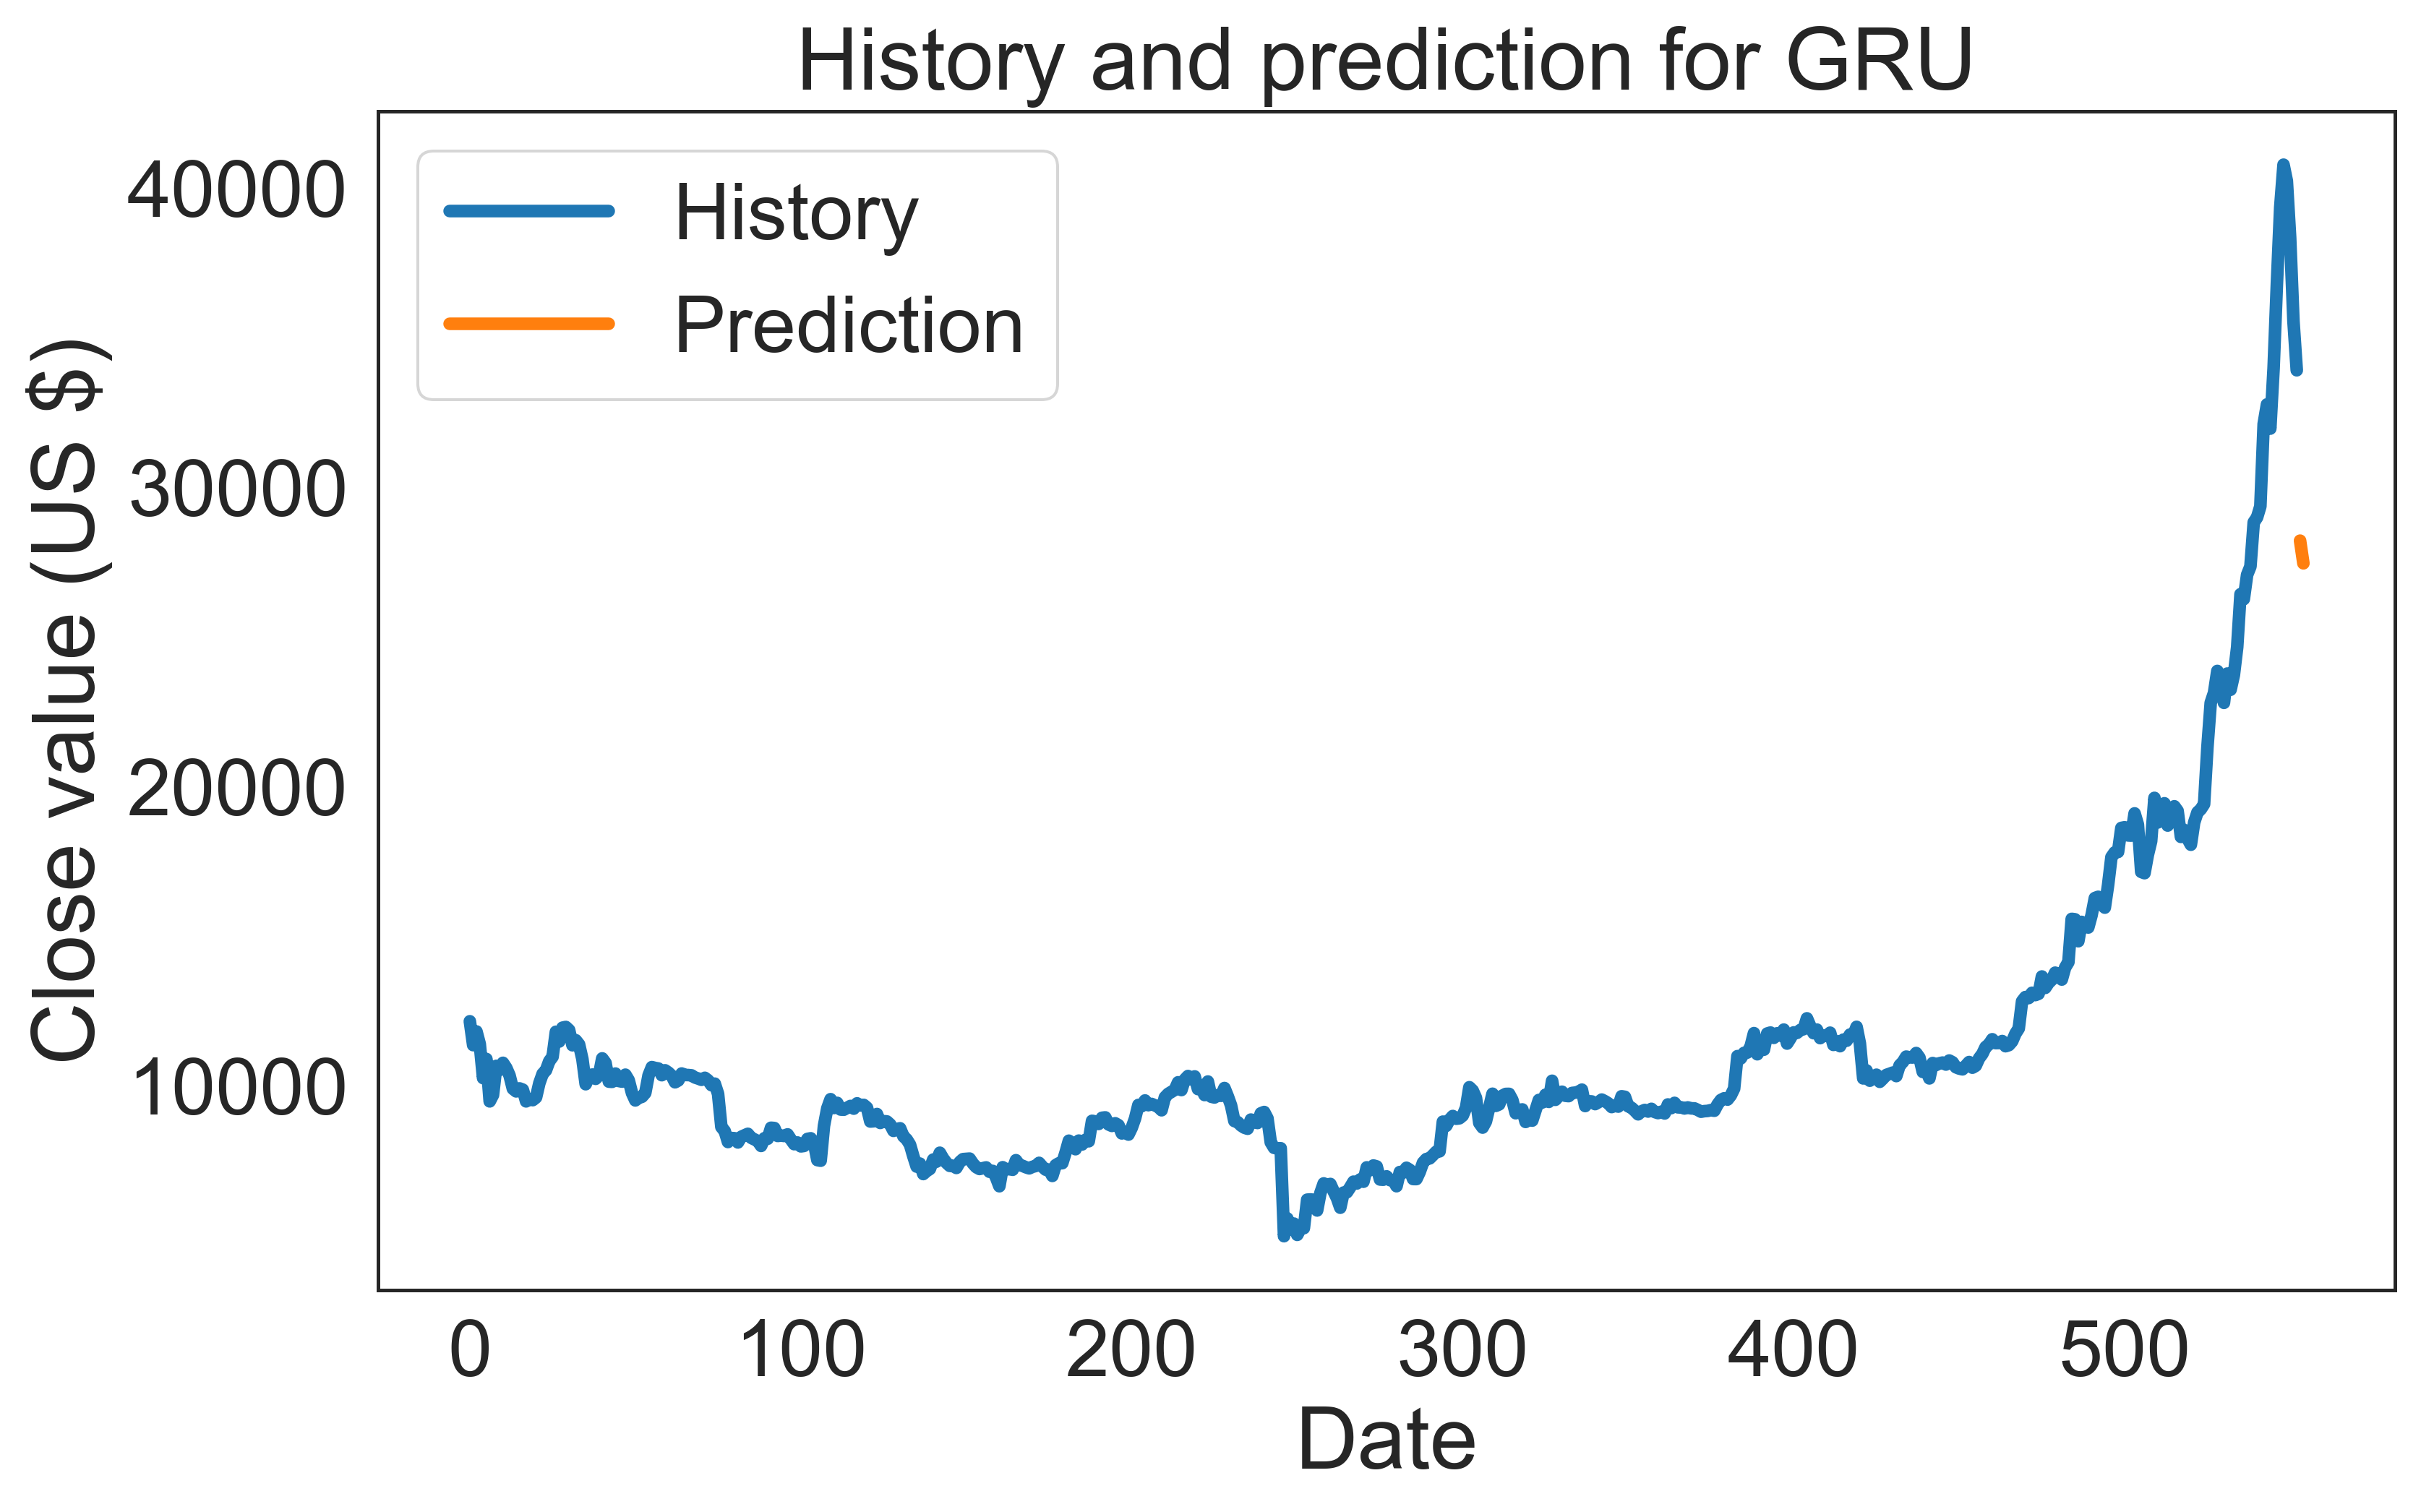

In [ ]:
def forecast(X_input, time_steps):
    # Scale the forecast input with the scaler fit on the training data
    X = input_scaler.transform(X_input)
    
    # Reshape forecast data as 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for forecast data using GRU model 
    prediction = model_gru.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual



prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_test, prediction,'GRU')

In [ ]:
prediction

array([[28226.107],
       [27468.18 ]], dtype=float32)